<a href="https://colab.research.google.com/github/Judykimani1/cord19_smoking_agent/blob/main/Smoking_Project_JudyKimani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦠 COVID & Smoking QnA Agent

This notebook will:

1. Install dependencies  
2. Download & extract CORD-19  
3. Filter by keywords & clean  
4. Extend with WHO COVID-19 data  
5. Keyword extraction & visualization  
6. Chunking, embeddings & FAISS index  
7. Gradio chatbot interface  
8. **Option A**: Validation tests  
9. **Option B**: Model-extension (NER & Sentiment)  


In [ ]:
# Install required libraries
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes \
            gradio keybert sentence-transformers faiss-cpu transformers wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 M

## 2. Imports & Helpers

In [ ]:
import os
import re
import pandas as pd
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image, display
from tqdm import tqdm

In [ ]:
# LlamaIndex imports
from llama_index.core import Settings, Document, StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer

## 3. Download & Extract CORD-19 (July 2020)

In [ ]:
# Upload
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_path = "/content/drive/My Drive/filtered_cord19_text_sha.csv"
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    raise FileNotFoundError("Please upload 'filtered_cord19_text_sha.csv' to your Google Drive.")
df.head()

,sha,text
0,00624a8e79f31fccd9cc02ac643e8481d78898af,"A new coronavirus, named SARS-CoV-2 by the Wor..."
1,00eaa28403c40a1892c493a5ca2df4ac1e6896f8,"With the outbreak of the COVID-19 pandemia, ro..."
2,00ec6e927034a7b70159a09a6e54b74d08ac03c8,COVID19 and acute lymphoblastic leukemias of c...
3,012df38102699db78d83961b6dcb2c1138c810c1,The SARS-CoV-2 pandemic is unprecedented in ou...
4,0144d88cb339012dc1a4b29bbd72962e528baf92,The unprecedented health care scenario caused ...


# 4. FILTER SMOKING-RELATED ABSTRACTS

In [ ]:
smoking_keywords = ['smoking','smoke','tobacco','nicotine','cigarette','vaping','e-cigarette','secondhand']
covid_keywords   = ['covid','covid-19','coronavirus','sars-cov-2']
cancer_keywords  = ['lung cancer','cancer','tumor','carcinoma']
ALL_TERMS = smoking_keywords + covid_keywords + cancer_keywords
pattern = re.compile(r"\b(" + "|".join(map(re.escape, ALL_TERMS)) + r")\b", re.IGNORECASE)

In [ ]:
def contains_terms(text: str) -> bool:
    if pd.isna(text): return False
    return bool(pattern.search(text))

def clean_text(text: str) -> str:
    if not isinstance(text, str): return ""
    return re.sub(r"\[.*?\]|\s+", " ", text).strip()

# 5. FILTER & CLEAN THE CORD19 SLICE

In [ ]:
df['text'] = df['text'].astype(str)
filtered = df[df['text'].apply(contains_terms)].copy()
filtered['clean_text'] = filtered['text'].apply(clean_text)
print(f"[INFO] Filtered abstracts: {len(filtered):,} rows")

[INFO] Filtered abstracts: 1,492 rows


# 6. EXTEND WITH GPE DATASET
## Spatial Data for CORD-19 (COVID-19 ORDC)

Locations (GPE or LOC only) were extracted from CORD-19 full text articles [2020-03-20 release] using spaCy. The results were then geocoded with ArcGIS Online. In its current form, this data is uncleaned.

This dataset was produced by Charlie Harper and Ben Gorham of The Freedman Center for Digital Scholarship (Kelvin Smith Library) at Case Western Reserve University and made use of the High Performance Computing Resource in the Core Facility for Advanced Research Computing at Case Western Reserve University.

In [ ]:
gpe_path = "/content/drive/My Drive/gpe_or_loc_in_body.csv"
if not os.path.exists(gpe_path):
    print("[WARNING] GPE dataset not found; skipping extension")
    extended = filtered.copy()
else:
    gpe = pd.read_csv(gpe_path)
    gpe = gpe.rename(columns={"Title":"title","Abstract":"abstract","DOI":"doi"})
    keep_cols = [c for c in ['sha','title','abstract','doi','publish_time'] if c in gpe]
    gpe = gpe[keep_cols]
    gpe = gpe[gpe['abstract'].apply(contains_terms)].copy()
    gpe['clean_abstract'] = gpe['abstract'].apply(clean_text)
    print(f"[INFO] GPE-filtered: {len(gpe):,} rows")
    extended = pd.concat([filtered, gpe], ignore_index=True)
    extended = extended.drop_duplicates(subset=['doi','sha'], keep='first')
    print(f"[INFO] Extended dataset: {len(extended):,} rows")

[INFO] GPE-filtered: 95,351 rows
[INFO] Extended dataset: 6,324 rows


In [ ]:
extended.to_csv("/content/drive/My Drive/extended_metadata.csv", index=False)

In [ ]:
extended.head(10)

,sha,text,clean_text,title,abstract,doi,publish_time,clean_abstract
0,00624a8e79f31fccd9cc02ac643e8481d78898af,"A new coronavirus, named SARS-CoV-2 by the Wor...","A new coronavirus, named SARS-CoV-2 by the Wor...",NaN,NaN,NaN,NaN,NaN
1,00eaa28403c40a1892c493a5ca2df4ac1e6896f8,"With the outbreak of the COVID-19 pandemia, ro...","With the outbreak of the COVID-19 pandemia, ro...",NaN,NaN,NaN,NaN,NaN
2,00ec6e927034a7b70159a09a6e54b74d08ac03c8,COVID19 and acute lymphoblastic leukemias of c...,COVID19 and acute lymphoblastic leukemias of c...,NaN,NaN,NaN,NaN,NaN
3,012df38102699db78d83961b6dcb2c1138c810c1,The SARS-CoV-2 pandemic is unprecedented in ou...,The SARS-CoV-2 pandemic is unprecedented in ou...,NaN,NaN,NaN,NaN,NaN
4,0144d88cb339012dc1a4b29bbd72962e528baf92,The unprecedented health care scenario caused ...,The unprecedented health care scenario caused ...,NaN,NaN,NaN,NaN,NaN
5,017fa72e2ab985213af241fd27da200b57a2ff95,The COVID-19 pandemic is impacting all urologi...,The COVID-19 pandemic is impacting all urologi...,NaN,NaN,NaN,NaN,NaN
6,01875a437a28422a2b857efab9d5c4b113bcdfbb,Bispecific monoclonal antibodies (BsMAb) are u...,Bispecific monoclonal antibodies (BsMAb) are u...,NaN,NaN,NaN,NaN,NaN
7,0197f22ffbd2d32a556d4c2490fa2c72583faef5,Aims: It is important to identify characterist...,Aims: It is important to identify characterist...,NaN,NaN,NaN,NaN,NaN
8,01f7ebedfcedde79ac1595a1561fa2e735a76622,There are growing concerns that the UK COVID-1...,There are growing concerns that the UK COVID-1...,NaN,NaN,NaN,NaN,NaN
9,02049ffbdb20997055c4def3516af0e6e40dd427,ADAR1 isoforms are adenosine deaminases that e...,ADAR1 isoforms are adenosine deaminases that e...,NaN,NaN,NaN,NaN,NaN


# 7. VALIDATION REPORT & BASIC VIZ

In [ ]:
report = {
    "original_rows": len(df),
    "filtered_rows": len(filtered),
    "gpe_rows": len(gpe),
    "extended_rows": len(extended),
    "null_abstracts": filtered['text'].isna().sum(),
    "avg_length": filtered['text'].str.split().map(len).mean()
}
pd.DataFrame([report]).to_csv("/content/drive/My Drive/validation_report.csv", index=False)
display(pd.DataFrame([report]).T)

,0
original_rows,1507.000000
filtered_rows,1492.000000
gpe_rows,95351.000000
extended_rows,6324.000000
null_abstracts,0.000000
avg_length,2588.671582


In [ ]:
# Keyword frequency plot
freq = {term: extended['abstract'].str.contains(term, case=False).sum() for term in ALL_TERMS}
plt.figure(figsize=(10,4))
sns.barplot(x=list(freq.keys()), y=list(freq.values()))
plt.xticks(rotation=45, ha='right')
plt.title("Term Frequency")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/term_frequency.png")
plt.close()

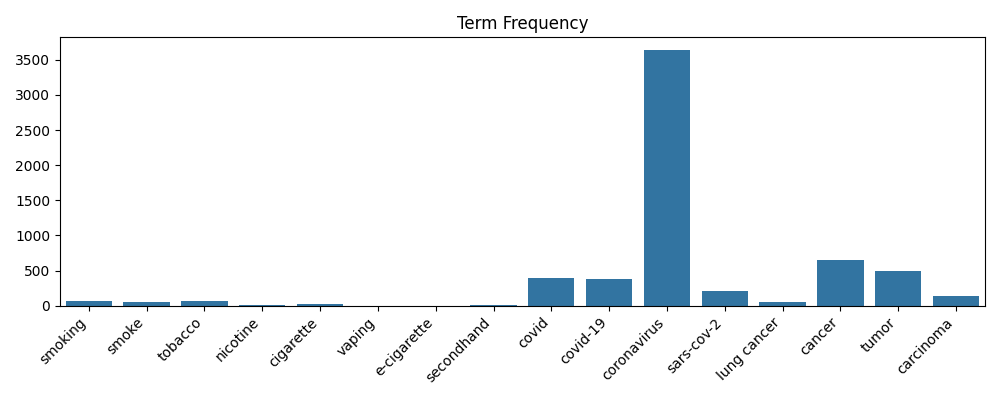

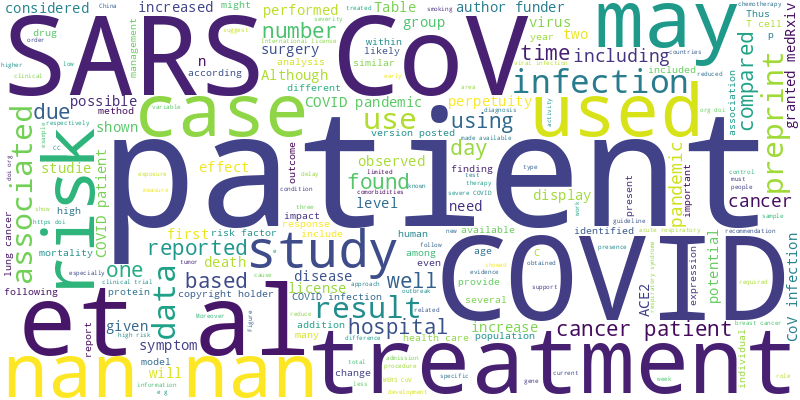

In [ ]:
# Wordcloud of extended abstracts
wc = WordCloud(width=800, height=400, background_color="white")
extended['text'] = extended['text'].astype(str).fillna('')
wc.generate(" ".join(extended['text']))
wc.to_file("/content/drive/My Drive/wordcloud.png")
display(Image("/content/drive/My Drive/term_frequency.png"))
display(Image("/content/drive/My Drive/wordcloud.png"))

# 8. KEYWORD EXTRACTION WITH KeyBERT

In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT("distilbert-base-nli-mean-tokens")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
all_kws = []
# Ensure that the 'clean_text' column has no NaN values before processing
extended['clean_text'] = extended['clean_text'].fillna('')
for txt in tqdm(extended['clean_text'], desc="Extracting keywords"):
    # The contains_terms and clean_text functions were applied earlier,
    # but ensuring no NaNs explicitly here handles potential edge cases
    # from concatenation or other operations.
    kws = [k for k,_ in kw_model.extract_keywords(txt, top_n=3)]
    all_kws.extend(kws)

Extracting keywords: 100%|██████████| 6324/6324 [04:53<00:00, 21.51it/s]


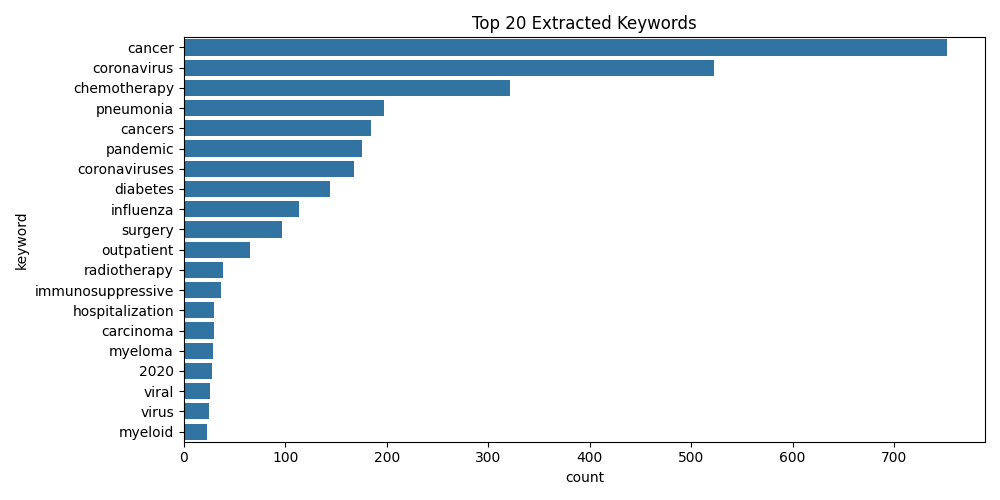

In [ ]:
top20 = Counter(all_kws).most_common(20)
kw_df = pd.DataFrame(top20, columns=['keyword','count'])
kw_df.to_csv("/content/drive/My Drive/top_keywords.csv", index=False)
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='keyword', data=kw_df)
plt.title("Top 20 Extracted Keywords")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/top_keywords.png")
plt.close()
display(Image("/content/drive/My Drive/top_keywords.png"))

# 9. CHUNK ABSTRACTS FOR INDEXING

In [ ]:
embed_model = HuggingFaceEmbedding(
    model_name="pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb",
    device="cuda"
)
Settings.embed_model = embed_model

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
chunks = []
for txt in tqdm(extended['clean_text'], desc="Chunking"):
    words = txt.split()
    for i in range(0, len(words), 150):
        chunk = " ".join(words[i:i+150])
        chunks.append(Document(text=chunk))

print(f"[INFO] Created {len(chunks):,} chunks")

Chunking: 100%|██████████| 6324/6324 [00:00<00:00, 7668.98it/s]

[INFO] Created 26,224 chunks


In [ ]:
index = VectorStoreIndex.from_documents(chunks, show_progress=True, insert_batch_size=len(chunks))
index.storage_context.persist(persist_dir="storage")

Parsing nodes:   0%|          | 0/26224 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/26224 [00:00<?, ?it/s]

# 9. QUERY EXAMPLE

In [ ]:
storage = StorageContext.from_defaults(persist_dir="storage")
index = load_index_from_storage(storage)

In [ ]:
from llama_index.llms.huggingface import HuggingFaceLLM

# 1. Create your HF LLM
hf_llm = HuggingFaceLLM(
    model_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",
    tokenizer_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",
    context_window=2048,
    max_new_tokens=256,
    device_map="cuda:0",
    generate_kwargs={"temperature":0.7, "do_sample":True},
)

# 2. Build the query engine with the LLM instance directly
query_engine = index.as_query_engine(
    similarity_top_k=10,
    llm=hf_llm # Pass the hf_llm instance directly
)

# 3. Run your query
response = query_engine.query("What are the effects of smoking.")
print(response.response)

adapter_config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

18 The effects of smoking are inconsistent, as smoking rates reported are lower than the population averages. However, smoking is recognized as a known risk factor for COVID-19 infection and possible outcome, in a mechanism involving the ability of the nicotinic receptor to regulate ACE2 protein expression in cells. Smoking also causes lung damage through the activation of inflammatory cytokines and programmed cell death in the pulmonary tissue and direct actions on circulating immune cells such as T cell. In addition to conventional cigarette smoking, e-cigarettes i.e. Electronic Nicotine Delivery Systems (ENDS) and JUICE USB Lighting (JUUL), waterpipe and other tobacco smoking devices, use nicotine products. Nicotine chemical derivatives are responsible for eroding the protective lining of lungs, damage of blood vessels and irregular endothelial surface leading to blood clotting and lethal embolism. Therefore, in the presence of existing chronic lung disease, the bronchial status of 

# 10. BUILD CHAT ENGINE & LAUNCH GRADIO

In [ ]:
Settings.llm = hf_llm

In [ ]:
chat_engine = index.as_chat_engine(
    chat_mode="context",
    memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
    system_prompt=(
        "You are a medical chatbot specialized in answering questions about Smoking, COVID-19, "
        "lung cancer, and related topics. Provide factual, safe responses based on the data."
    ),
    llm=hf_llm
)

# 11.  NER & SENTIMENT ANNOTATION

In [ ]:
from transformers import pipeline

# 1. Initialize the NER pipeline
ner = pipeline(
    task="ner",
    model="d4data/biomedical-ner-all",
    tokenizer="d4data/biomedical-ner-all",
    grouped_entities=True,
    device=0
)

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [ ]:
# 2. Updated chat function that annotates the generated answer
def chat_fn_with_ner(user_input, history=[]):
    # Get the response from the chat engine
    result = chat_engine.chat(user_input)
    answer = result.response

    # Run NER on the answer
    entities = ner(answer)

    # Append to chat history
    history.append((user_input, answer))

    # Return updated history and NER entities
    return history, history, entities

🧠 COVID & Smoking QnA Chatbot
This Gradio-based app allows users to ask medical questions related to COVID-19, smoking, and lung cancer. It features:

✅ LLM-powered chatbot (Llama 3.2 1B Mango)

✅ Named Entity Recognition (Biomedical NER)

✅ Sentiment Analysis (on user & bot text)

✅ Model dropdown for future extensibility

In [ ]:
from transformers import pipeline
import gradio as gr

# 1. Initialize NER and Sentiment Analysis Pipelines
ner_pipeline = pipeline(
    task="ner",
    model="d4data/biomedical-ner-all",
    tokenizer="d4data/biomedical-ner-all",
    grouped_entities=True,
    device=0
)

sentiment_pipeline = pipeline(
    task="sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",  # Or replace with a medical sentiment model
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    device=0
)

# 2. Chat function with NER and Sentiment Analysis
def full_chat_fn(user_input, history=[]):
    # Get response from chat engine
    result = chat_engine.chat(user_input)
    answer = result.response

    # Run NER on the generated answer
    ner_results = ner_pipeline(answer)

    # Run Sentiment Analysis on the answer
    sentiment_results = sentiment_pipeline(answer)

    # Append to chat history
    history.append((user_input, answer))

    return history, history, ner_results, sentiment_results

# 3. Gradio Wrapper
def wrapped_chat(user_input, history):
    return full_chat_fn(user_input, history)

# 4. Interface Definition
chatbot = gr.Chatbot(label="🧠 Medical Chat")
state   = gr.State([])

iface = gr.Interface(
    fn=wrapped_chat,
    inputs=[gr.Textbox(lines=2, label="Your Question", placeholder="e.g., What are the effects of smoking on COVID-19 patients?"), state],
    outputs=[
        chatbot,                 # Updated chat history
        state,                   # Stateful memory
        gr.JSON(label="🔬 Named Entities"),
        gr.JSON(label="❤️ Sentiment Analysis")
    ],
    title="🦠 COVID & Smoking QnA Agent",
    description="Ask about COVID-19, smoking, lung cancer, or related medical topics. Output includes NER and sentiment insights."
)

iface.launch()


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-30-1fab330a5234>:42: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="🧠 Medical Chat")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0a3f0d11a5aed95238.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
